## Autoencoater

### Подготовка данных

In [ ]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import os
import pandas as pd
import skimage.io
from skimage.transform import resize
import tqdm

import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

### Обучение

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    # Скачиваем датасет и атрибуты если ранее не существовало
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("Датасет скачан")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("Датасет скачан")

    #Создаем датафрейм с атрибутами
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #Создаем датафрейм с фото
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)

    #Группируем фото и атрибуты в одном порядке
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"проверяем совпадает ли размеры, чтобы убедиться что число фото и атребутов совпадают"

    # print(df.shape)
    # Обрезаем и массштабируем изображения
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

### Загрузка датасета

In [ ]:
data, attrs = fetch_dataset()

images not found, donwloading...


--2023-12-12 17:13:51--  http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108761145 (104M) [application/x-gzip]
Saving to: ‘tmp.tgz’

     0K .......... .......... .......... .......... ..........  0%  632K 2m48s
    50K .......... .......... .......... .......... ..........  0%  935K 2m21s
   100K .......... .......... .......... .......... ..........  0%  701K 2m24s
   150K .......... .......... .......... .......... ..........  0%  173M 1m48s
   200K .......... .......... .......... .......... ..........  0%  137K 4m1s
   250K .......... .......... .......... .......... ..........  0%  144M 3m21s
   300K .......... .......... .......... .......... ..........  0%  745K 3m12s
   350K .......... .......... .......... .......... ..........  0%  164M 2m48s
   400K .....

extracting...
lfw-deepfunneled/AJ_Cook/AJ_Cook_0001.jpg
lfw-deepfunneled/AJ_Lamas/AJ_Lamas_0001.jpg
lfw-deepfunneled/Aaron_Eckhart/Aaron_Eckhart_0001.jpg
lfw-deepfunneled/Aaron_Guiel/Aaron_Guiel_0001.jpg
lfw-deepfunneled/Aaron_Patterson/Aaron_Patterson_0001.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0001.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0002.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0003.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0004.jpg
lfw-deepfunneled/Aaron_Pena/Aaron_Pena_0001.jpg
lfw-deepfunneled/Aaron_Sorkin/Aaron_Sorkin_0001.jpg
lfw-deepfunneled/Aaron_Sorkin/Aaron_Sorkin_0002.jpg
lfw-deepfunneled/Aaron_Tippin/Aaron_Tippin_0001.jpg
lfw-deepfunneled/Abba_Eban/Abba_Eban_0001.jpg
lfw-deepfunneled/Abbas_Kiarostami/Abbas_Kiarostami_0001.jpg
lfw-deepfunneled/Abdel_Aziz_Al-Hakim/Abdel_Aziz_Al-Hakim_0001.jpg
lfw-deepfunneled/Abdel_Madi_Shabneh/Abdel_Madi_Shabneh_0001.jpg
lfw-deepfunneled/Abdel_Nasser_Assidi/Abdel_Nasser_Assidi_0001.jpg
lfw-deepfunneled

--2023-12-12 17:14:49--  http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
Resolving www.cs.columbia.edu (www.cs.columbia.edu)... 128.59.11.206
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt [following]
--2023-12-12 17:14:49--  https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14879205 (14M) [text/plain]
Saving to: ‘lfw_attributes.txt’

     0K .......... .......... .......... .......... ..........  0% 1.35M 10s
    50K .......... .......... .......... .......... ..........  0% 2.70M 8s
   100K .......... .......... .......... .......... ..........  1% 2.78M 7s
   150K .......... .......... .......... .

done


### Разбиваем выборку на обучающую и валидационную


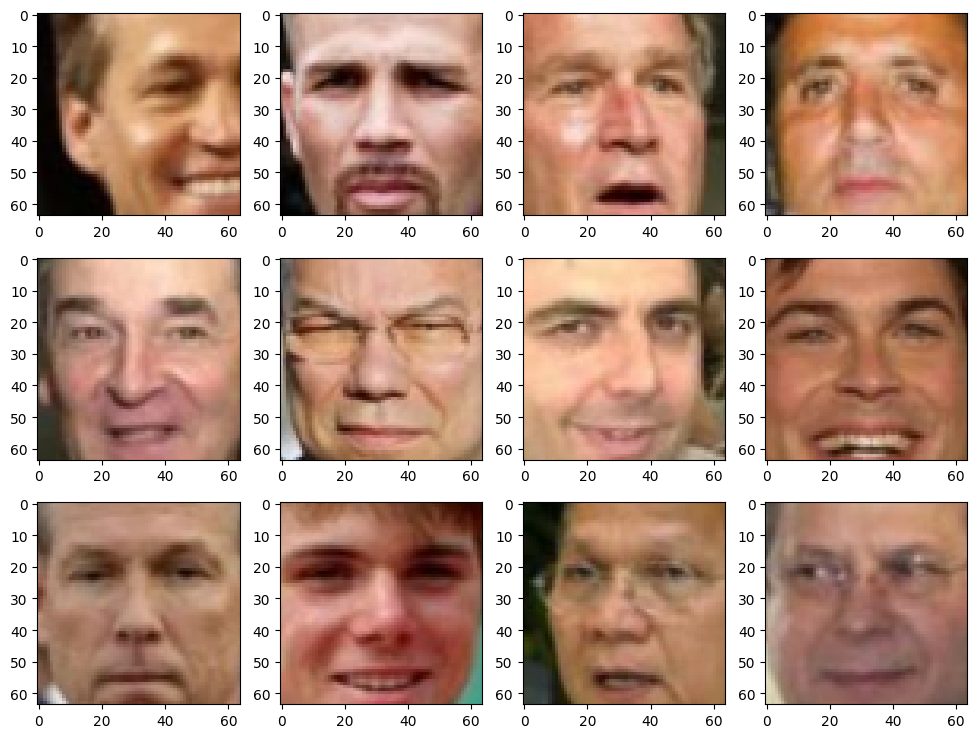

In [ ]:
train_photos, val_photos, train_attrs, val_attrs = train_test_split(data, attrs, test_size=0.1, shuffle=True, random_state=42)

plt.figure(figsize=(12, 9))
for i, photo in enumerate(train_photos[:12]):
    plt.subplot(3, 4, i+1)
    plt.imshow(photo)

# Так как Conv2d принимает tansor в формате NCHW (https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
# А у нас NHWC, то изменим порядок осей в тензоре
train_photos_tensor = torch.tensor(train_photos).permute(0, 3, 1, 2)
val_photos_tensor = torch.tensor(val_photos).permute(0, 3, 1, 2)

train_loader = torch.utils.data.DataLoader(train_photos_tensor, batch_size=64, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_photos_tensor, batch_size=64, drop_last=True)

In [ ]:
shape = train_photos_tensor[0].shape
shape

torch.Size([3, 64, 64])

In [ ]:
def train(model, optimizer, criterion, n_epochs: int):

    train_losses = []
    val_losses = []

    for epoch in tqdm.tqdm(range(n_epochs)):
        model.train()
        train_losses_per_epoch = []
        for batch in train_loader:
            batch = batch.float().to(device)
            optimizer.zero_grad()
            reconstruction, latent_code = model(batch)
            loss = criterion(reconstruction, batch)
            loss.backward()
            optimizer.step()
            train_losses_per_epoch.append(loss.item())

        train_losses.append(np.mean(train_losses_per_epoch))
        print(f"Epoch {epoch + 1}: train loss {float(loss):.4f}")

        model.eval()
        val_losses_per_epoch = []
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.float().to(device)
                reconstruction, latent_code = model(batch)
                loss = criterion(reconstruction, batch)
                val_losses_per_epoch.append(loss.item())

        val_losses.append(np.mean(val_losses_per_epoch))
        print(f"Epoch {epoch + 1}: val loss {float(loss):.4f}")

        clear_output(wait=True)
        plt.figure(figsize=(14, 8))
        for k in range(6):
            plt.subplot(3, 6, k+1)
            plt.imshow(np.rollaxis(batch[k].cpu().numpy(), 0, 3))
            plt.title('Original')
            plt.axis('off')

            plt.subplot(3, 6, k+7)
            plt.imshow(np.rollaxis(reconstruction[k].cpu().numpy(), 0, 3))
            plt.title('Reconstructed')
            plt.axis('off')

        plt.suptitle('%d / %d - loss: %f' % (epoch+1, n_epochs, loss))
        plt.show()

    return {'train': train_losses, 'valid': val_losses}

### Архитектура модели

In [ ]:
class Autoencoder(nn.Module):

    def __init__(self, code_size):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.ReLU(),
            nn.Flatten(),  # batch_size x 64 * 4 * 4
            nn.Linear(64 * 4 * 4, code_size),
        )

        self.decoder = nn.Sequential(
            nn.Linear(code_size, 64 * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(1, (64, 4, 4)),
            nn.ConvTranspose2d(64, 32, 3, 2, 1, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, 2, 1, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 3, 2, 1, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, 3, 2, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        return reconstruction, latent_code


    def sample(self, latent_code):
        return self.decoder(latent_code)

### Обучение

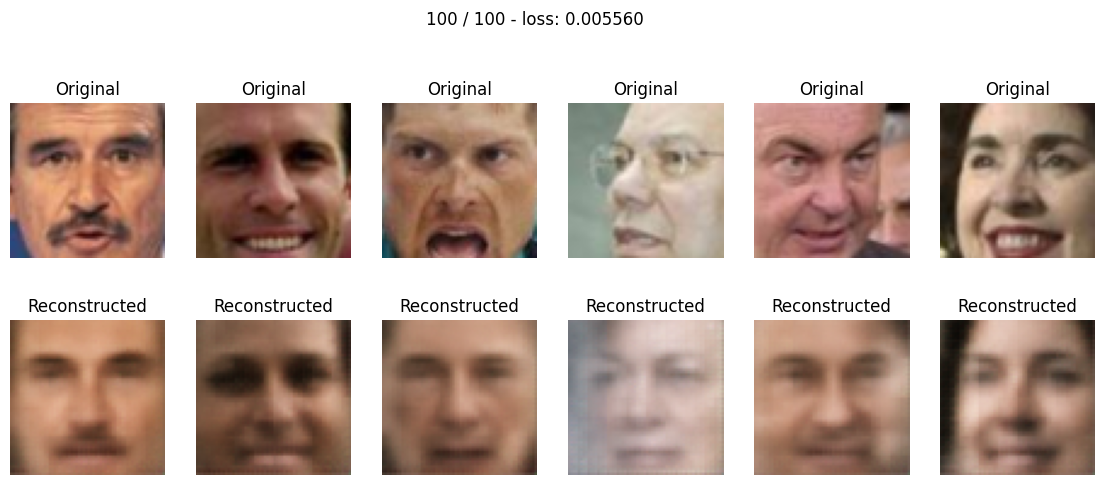

100%|██████████| 100/100 [04:02<00:00,  2.42s/it]


In [ ]:
criterion = nn.MSELoss()
autoencoder = Autoencoder(256).to(device)
optimizer = torch.optim.AdamW(autoencoder.parameters(), lr=1e-4)

losses = train(autoencoder, optimizer, criterion, 100)

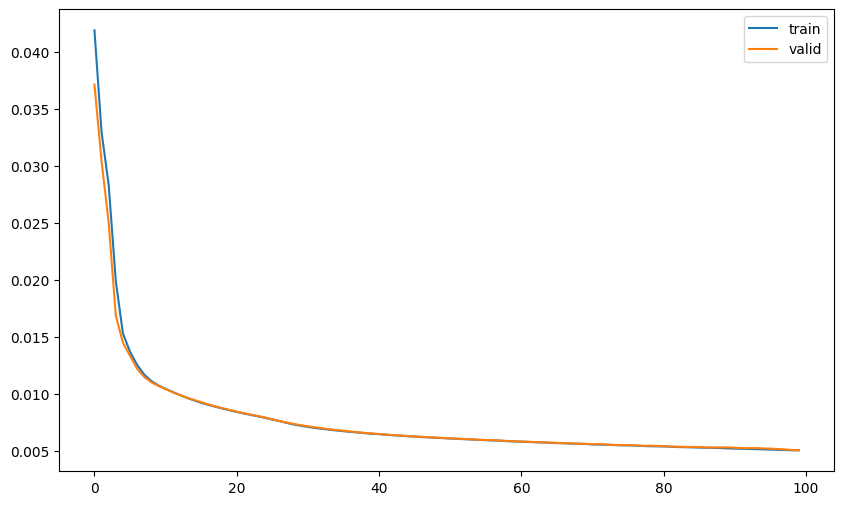

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot([float(loss) for loss in losses['train']], label="train")
plt.plot([float(loss) for loss in losses['valid']], label="valid")
plt.legend()
plt.show()

### Создание семплов

In [ ]:
random_vectors = np.random.randn(5, 256)
output = autoencoder.sample(torch.FloatTensor(random_vectors).to(device))

In [ ]:
random_vectors.mean(), random_vectors.std()

(0.029397611137997538, 0.9570000464929628)

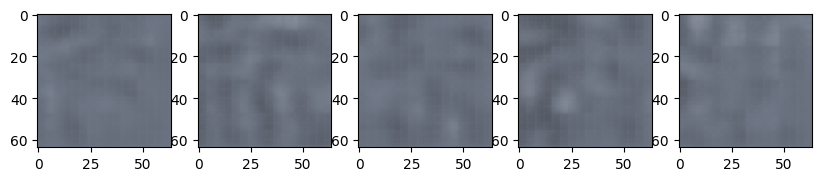

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(output.shape[0]):
    plt.subplot(1, 5, i + 1)
    generated = output[i].cpu().detach().numpy()
    generated = np.transpose(generated, (1, 2, 0))
    plt.imshow(generated)

plt.show()

In [ ]:
latent_vectors = torch.Tensor()

for batch in train_loader:
    _, latent_vector = autoencoder(batch.float().to(device))
    latent_vectors = torch.cat((latent_vectors, latent_vector.cpu().detach()), 0)

In [ ]:
mean = torch.mean(latent_vectors, axis=0).numpy()
std = torch.std(latent_vectors, axis=0).numpy()

### Результат отличается от ожидаемого в силу того, что латентный вектор имеет другое распределение

In [ ]:
correct = 0.5 * std * random_vectors + 2 * mean

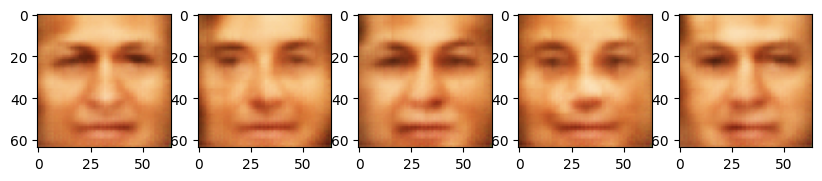

In [ ]:
output = autoencoder.sample(torch.FloatTensor(correct).to(device))

plt.figure(figsize=(10, 10))
for i in range(output.shape[0]):
    plt.subplot(1, 5, i + 1)
    generated = output[i].cpu().detach().numpy()
    generated = np.transpose(generated, (1, 2, 0))
    plt.imshow(generated)

plt.show()

### Редактирование улыбки

In [ ]:
attrs.head()

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,...,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,1.568346,-1.889043,1.737203,-0.929729,-1.471799,-0.19558,-0.835609,-0.351468,-1.012533,-0.719593,...,0.361738,1.166118,-1.164916,-1.13999,-2.371746,-1.299932,-0.414682,-1.144902,0.694007,-0.826609
1,0.169851,-0.982408,0.422709,-1.282184,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,...,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.006244,-0.030406,-0.480128,0.66676,-0.496559
2,0.997749,-1.364195,-0.157377,-0.756447,-1.891825,-0.871526,-0.862893,0.031445,-1.341523,-0.090037,...,1.549743,1.884745,-0.999765,-1.359858,-1.912108,-1.095634,0.915126,-0.572332,0.144262,-0.841231
3,1.122719,-1.997799,1.916144,-2.514214,-2.580071,-1.404239,0.057551,0.000196,-1.273512,-1.431462,...,0.567822,-0.176089,1.108125,-1.600944,-3.264613,0.813418,0.308631,-0.848693,0.475941,-0.447025
4,1.078214,-2.008098,1.676211,-2.278056,-2.651845,-1.348408,0.649089,0.017656,-1.889111,-1.857213,...,-1.461474,-0.955283,0.119113,-1.128176,-3.161048,0.08268,-0.439614,-0.359859,-0.760774,-0.410152


### Отберем 20 улыбающихся и грустных лиц в атрибутах

In [ ]:
smile_indices = attrs.sort_values(by='Smiling', ascending=False).head(20).index
sad_indices = attrs.sort_values(by='Arched Eyebrows', ascending=False).head(20).index

In [ ]:
smile_data = data[smile_indices]
sad_data = data[sad_indices]

In [ ]:
smile_tensor = torch.tensor(smile_data).permute(0, 3, 1, 2)
sad_tensor = torch.tensor(sad_data).permute(0, 3, 1, 2)

smile_tensor.size()

torch.Size([20, 3, 64, 64])

In [ ]:
with torch.no_grad():
    smile_latent_code = autoencoder.encoder(smile_tensor.to(device).float())
    sad_latent_code = autoencoder.encoder(sad_tensor.to(device).float())

smile_latent_code.size()

torch.Size([20, 256])

### Считаем средний латентый вектор для лиц с улыбкой для грустных лиц

In [ ]:
mean_smile = smile_latent_code.mean(dim=0)
mean_sad = sad_latent_code.mean(dim=0)

mean_smile.size()

torch.Size([256])

### Добаляем разницу между этими средними - вектор направления улыбки к латентным векторам грустных лиц

In [ ]:
latent = sad_latent_code + (mean_smile - mean_sad)
latent.size()

torch.Size([20, 256])

In [ ]:
with torch.no_grad():
    reconstructeds = autoencoder.decoder(latent).cpu().numpy().transpose(0, 2, 3, 1)

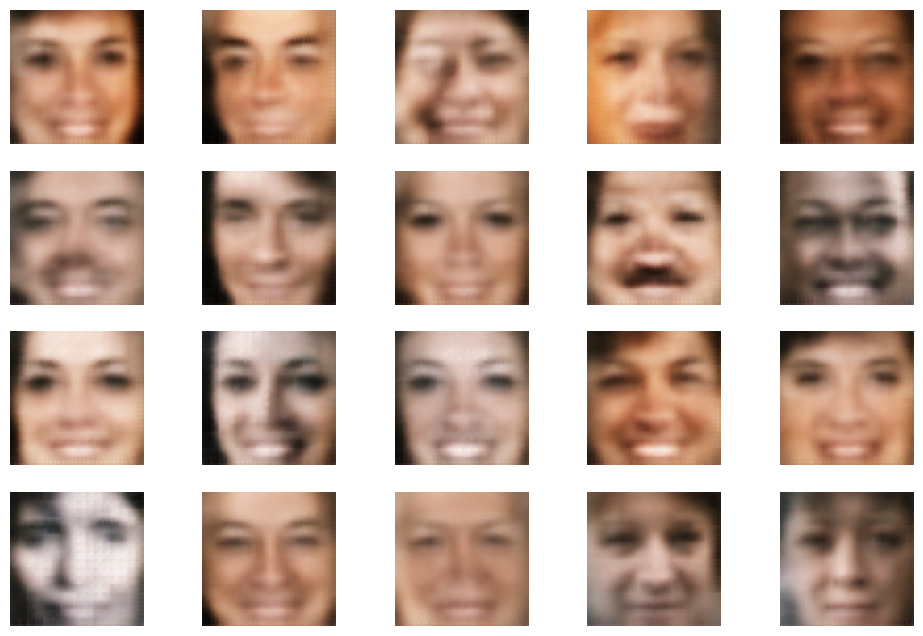

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    ax.imshow(reconstructeds[i])
    ax.set_axis_off()

plt.show()

## Variational Autoencoder

In [ ]:
batch_size = 32

# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 100984963.02it/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 43247302.33it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 22934324.42it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6996154.52it/s]


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [ ]:
shape = next(iter(train_loader))[0].shape
shape

torch.Size([32, 1, 28, 28])

### Архитектура модели и обучение

In [ ]:
features = 16


class VAE(nn.Module):
    def __init__(self, features):
        super(VAE, self).__init__()

        self.features = features

        # encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(14 * 14 * 32, 128),
            nn.ReLU(),
            nn.Linear(128, self.features * 2)
        )

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(self.features, 128),
            nn.ReLU(),
            nn.Linear(128, 14 * 14 * 32),
            nn.ReLU(),
            nn.Unflatten(1, (32, 14, 14)),
            nn.Dropout(0.25),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )


    def reparameterize(self, mu, log_var):
        """
        :параметр mu: среднее из латентного пространства энкодера
        :параметр log_var: логарифм дисперсии из латентного пространства энкодера
        """
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        sample = mu + (eps * std)
        return sample

    def forward(self, x):
        # encoding
        mu, logsigma = self.get_latent_vector(x)
        z = self.reparameterize(mu, logsigma)
        reconstruction = self.decoder(z)
        return reconstruction, mu, logsigma

    def sample(self, z):
        generated = self.decoder(z)
        generated = generated.view(-1, 28, 28, 1)
        return generated

    def get_latent_vector(self, x):
        x = self.encoder(x).view(-1, 2, self.features)
        mu = x[:, 0, :]  # первый признак средее
        log_var = x[:, 1, :]  # второй признак дисперсия
        return mu, log_var

Определяем функцию потерь как сумму KL-дивергенции и Log-likelihood (reconstruction loss), за которую берем бинарную кросс-энтропию

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    приближает их распределение к нормальному
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

### Обучение

In [ ]:
criterion = loss_vae
vae = VAE(16).to(device)
optimizer = torch.optim.AdamW(vae.parameters())

In [ ]:
n_epochs = 50

train_losses = []
val_losses = []

for epoch in tqdm.tqdm(range(n_epochs)):
    vae.train()
    train_losses_per_epoch = []
    for batch, _ in train_loader:
        optimizer.zero_grad()
        batch = batch.to(device).float()
        reconstruction, mu, logsigma = vae(batch)
        loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))
    print(f"Epoch {epoch + 1}: train loss {float(loss):.4f}")

    vae.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch, _ in test_loader:
            batch = batch.to(device).float()
            reconstruction, mu, logsigma = vae(batch)
            loss = criterion(batch, mu, logsigma, reconstruction)
            val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))
    print(f"Epoch {epoch + 1}: val loss {float(loss):.4f}")

    clear_output(wait=True)
    plt.figure(figsize=(14, 8))
    for k in range(6):
        plt.subplot(3, 6, k+1)
        plt.imshow(np.rollaxis(batch[k].cpu().numpy(), 0, 3))
        plt.title('Original')
        plt.axis('off')

        plt.subplot(3, 6, k+7)
        plt.imshow(np.rollaxis(reconstruction[k].cpu().numpy(), 0, 3))
        plt.title('Reconstructed')
        plt.axis('off')

    plt.suptitle('%d / %d - loss: %f' % (epoch+1, n_epochs, loss))
    plt.show()

In [ ]:
checkpoint = {'model': VAE(16),
              'state_dict': vae.state_dict(),
              'optimizer' : optimizer.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot([float(loss) for loss in train_losses], label="train")
plt.plot([float(loss) for loss in val_losses], label="valid")
plt.legend()
plt.show()

In [ ]:
z = np.random.randn(6, 16)
output = vae.sample(torch.FloatTensor(z).to(device))
output.shape

In [ ]:
plt.figure(figsize=(20, 10))

for i in range(output.shape[0]):
    plt.subplot(1, 6, i + 1)
    generated = output[i].cpu().detach().numpy().squeeze()
    plt.imshow(generated, cmap='gray', vmin=0, vmax=1)

plt.show()

### Визуализируем латентное представление через снижение размерности до плоскости

In [ ]:
from sklearn.manifold import TSNE

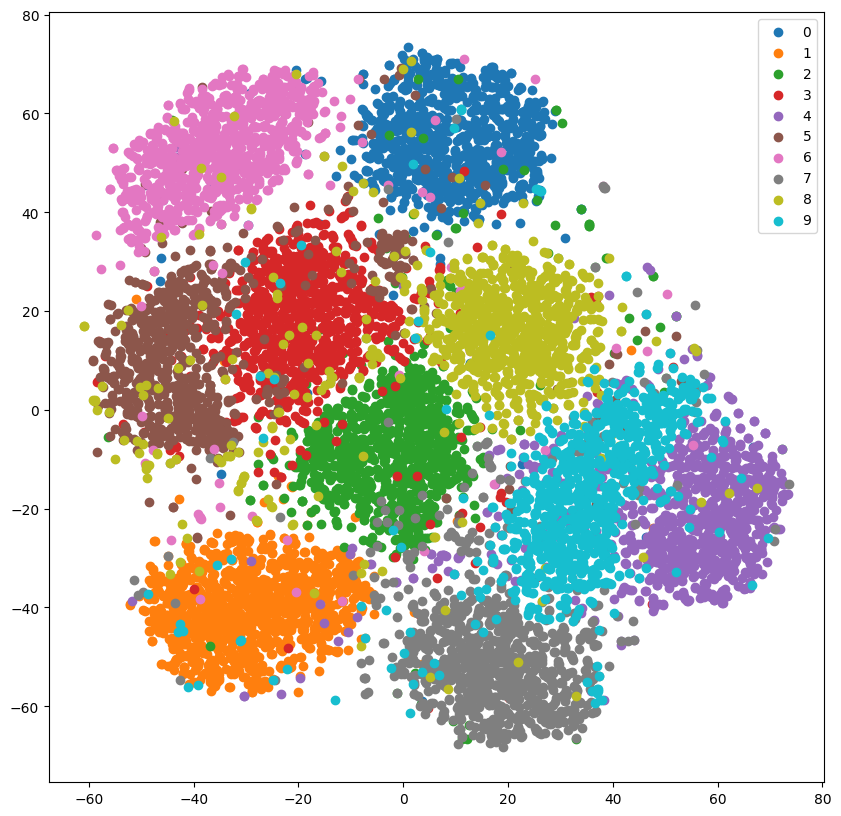

In [ ]:
latent_vectors = []
labels = []
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device)
        mu, logvar = vae.get_latent_vector(data)
        z = vae.reparameterize(mu, logvar)
        latent_vectors.append(z.cpu().numpy())
        labels.append(target.cpu().numpy())
latent_vectors = np.concatenate(latent_vectors, axis=0)
labels = np.concatenate(labels, axis=0)

tsne = TSNE(n_components=2)
latent_vectors_tsne = tsne.fit_transform(latent_vectors)

plt.figure(figsize=(10, 10))
for i in range(10):
    plt.scatter(latent_vectors_tsne[labels == i, 0], latent_vectors_tsne[labels == i, 1], label=str(i))
plt.legend()
plt.show()

## Conditional VAE

In [ ]:
class CVAE(nn.Module):
    def __init__(self):

        super(CVAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 2, 1),
            nn.ReLU(),
        )


        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, 3, 2, 1, 1),
            nn.ReLU(),
            nn.Conv2d(64, 32, 3, 1, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 3, 2, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 1, 3, 1, 1),
            nn.Sigmoid()
        )


        self.flatten = nn.Flatten(1)


        self.mu = nn.Sequential(
            nn.Linear(3136, 32)
        )

        self.logsigma = nn.Sequential(
            nn.Linear(3136, 32)
        )

        self.decoder_with_labels = nn.Sequential(
            nn.Linear(42, 3136),
            nn.ReLU()
        )

        self.unflatten = nn.Sequential(
            nn.Unflatten(
                dim=1,
                unflattened_size=(64, 7, 7)
            )
        )

    def encode(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        mu = self.mu(x)
        logsigma = self.logsigma(x)
        return mu, logsigma


    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            return eps * std + mu
        else:
            return mu


    def decode(self, x):
        x = self.decoder_with_labels(x)
        x = self.unflatten(x)
        x = self.decoder(x)
        return x


    def forward(self, x):
        images, labels = x
        labels = F.one_hot(labels, 10)

        mu, logsigma = self.encode(images)
        reparameterize = self.gaussian_sampler(mu, logsigma)
        output = torch.cat([reparameterize, labels], dim = 1)
        output = self.decode(output)
        return output, mu, logsigma

    def sample(self, labels: list):
        y = torch.tensor(labels, dtype=torch.int64).to(device)
        y = F.one_hot(y, num_classes=10)
        z = torch.randn(y.size()[0], 32).to(device)
        z = torch.cat([z, y], dim=1)
        return self.decode(z)

In [ ]:
criterion = loss_vae
cvae = CVAE().to(device)
optimizer = torch.optim.AdamW(cvae.parameters())

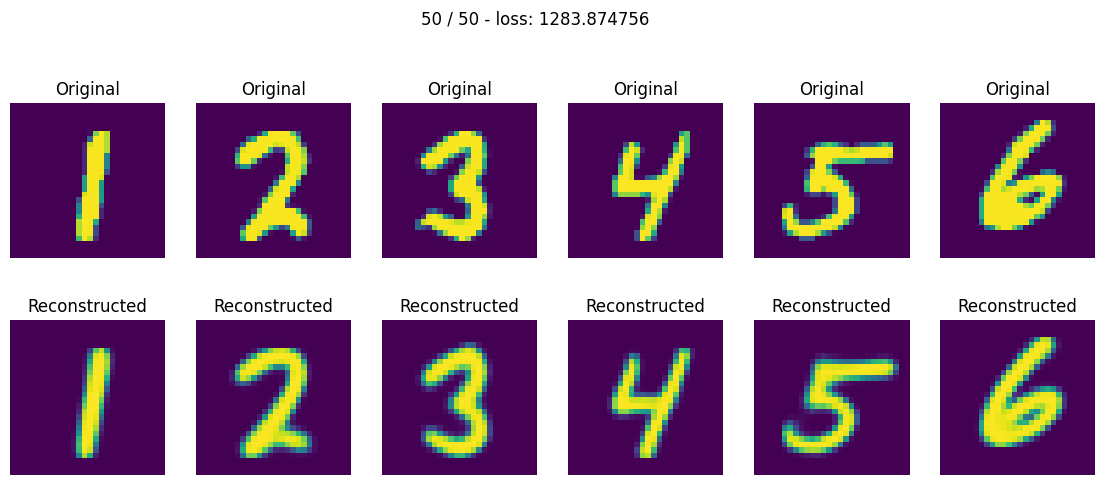

100%|██████████| 50/50 [15:31<00:00, 18.62s/it]


In [ ]:
n_epochs = 50

train_losses = []
val_losses = []

for epoch in tqdm.tqdm(range(n_epochs)):
    cvae.train()
    train_losses_per_epoch = []
    for batch, labels in train_loader:
        optimizer.zero_grad()
        batch = batch.to(device).float()
        labels = labels.to(device)
        reconstruction, mu, logsigma = cvae([batch, labels])
        loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))
    print(f"Epoch {epoch + 1}: train loss {float(loss):.4f}")

    cvae.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch, labels in test_loader:
            batch = batch.to(device).float()
            labels = labels.to(device)
            reconstruction, mu, logsigma = cvae([batch, labels])
            loss = criterion(batch, mu, logsigma, reconstruction)
            val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))
    print(f"Epoch {epoch + 1}: val loss {float(loss):.4f}")

    clear_output(wait=True)
    plt.figure(figsize=(14, 8))
    for k in range(6):
        plt.subplot(3, 6, k+1)
        plt.imshow(np.rollaxis(batch[k].cpu().numpy(), 0, 3))
        plt.title('Original')
        plt.axis('off')

        plt.subplot(3, 6, k+7)
        plt.imshow(np.rollaxis(reconstruction[k].cpu().numpy(), 0, 3))
        plt.title('Reconstructed')
        plt.axis('off')

    plt.suptitle('%d / %d - loss: %f' % (epoch+1, n_epochs, loss))
    plt.show()

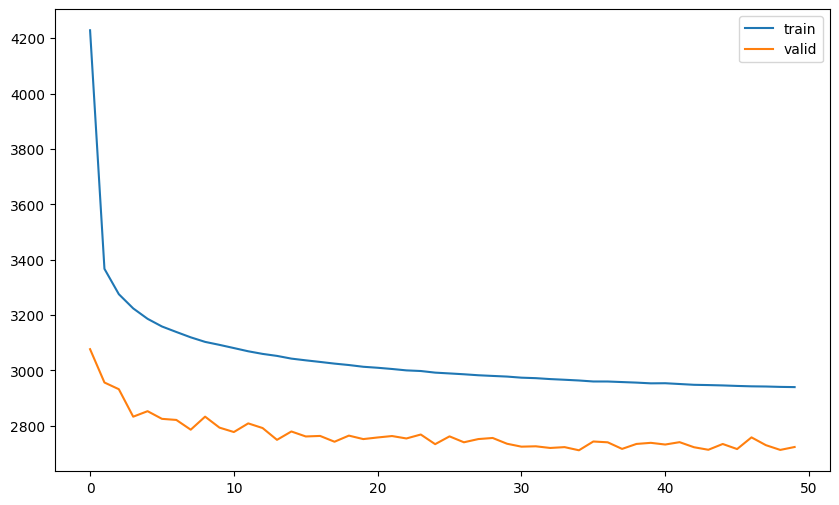

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot([float(loss) for loss in train_losses], label="train")
plt.plot([float(loss) for loss in val_losses], label="valid")
plt.legend()
plt.show()

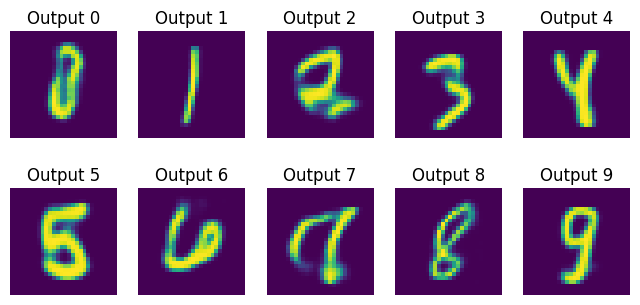

In [ ]:
nums = range(10)
output_num = cvae.sample(nums).cpu().detach()

plt.figure(figsize=(8, len(nums)*2))
for i, n in enumerate(nums):
    plt.subplot(len(nums), 5, i+1)
    plt.imshow(output_num[i].permute(1, 2, 0))
    plt.title(f'Output {n}')
    plt.axis('off')
plt.show()

In [ ]:
cvae.eval()
None

In [ ]:
latents_values = torch.Tensor()
labels_values = torch.Tensor()

for batch, label in test_loader:
    _, mu, logsigma = cvae([batch.to(device), label.to(device)])
    latent = cvae.gaussian_sampler(mu, logsigma)
    latents_values = torch.cat((latents_values, latent.to('cpu')), 0)
    labels_values = torch.cat((labels_values, label.to('cpu')), dim=0)

In [ ]:
TSNE_latent = TSNE(n_components=2, init="pca", learning_rate="auto")
TSNE_latent = TSNE_latent.fit_transform(latents_values.detach().numpy())

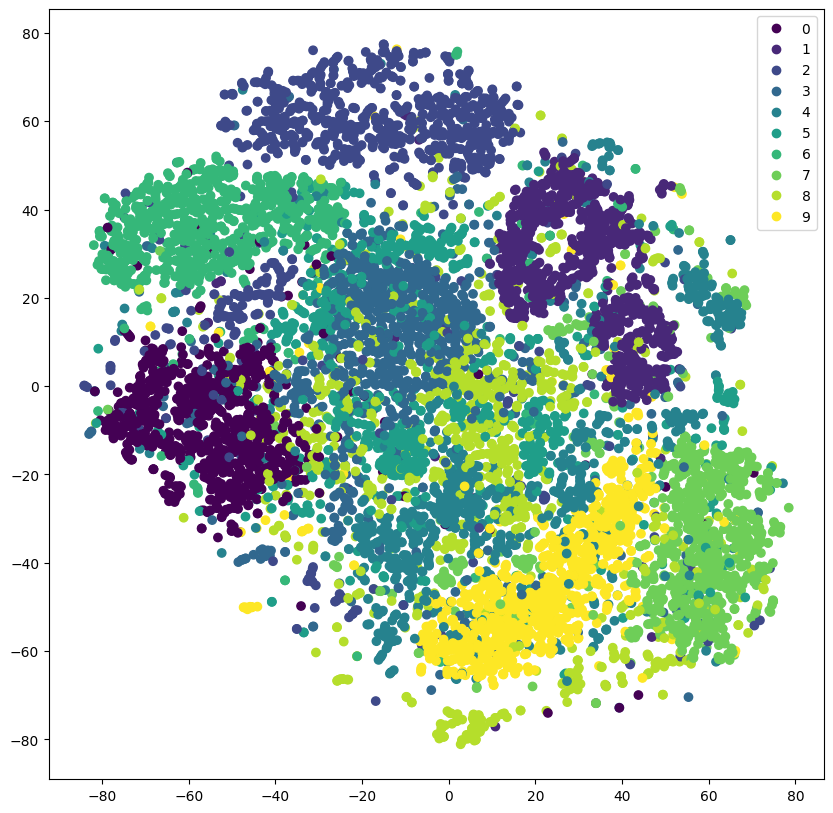

In [ ]:
plt.figure(figsize=(10, 10))
scatter = plt.scatter(TSNE_latent[:, 0], TSNE_latent[:, 1], c=labels_values)
plt.legend(*scatter.legend_elements())
plt.show()

Видно что в отличие от латентного пространства VAE кластеры цифр нечектие